In [54]:
import cv2
import os
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import imutils
import glob 

In [60]:
scriptDir = Path("D:\\VSC\\machine-learning-crash-course\\deep-neural-networks\\computer-vision\\template_matching.ipynb").resolve()
projectRoot = scriptDir.parent.parent.parent
imagePath = os.path.join(projectRoot, "assets/finding_15")
templatePath = os.path.join(imagePath, "template")
plt.rcParams['figure.figsize'] = (12, 10)  # Set default figure size for all plots

In [58]:
imgBGR = cv2.imread(os.path.join(imagePath, 'finding.jpg')) # BGR
gray = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2GRAY)
boat_template = cv2.imread(os.path.join(imagePath, 'template/boat.png'), 0) # gray

# Template matching on grayscale image

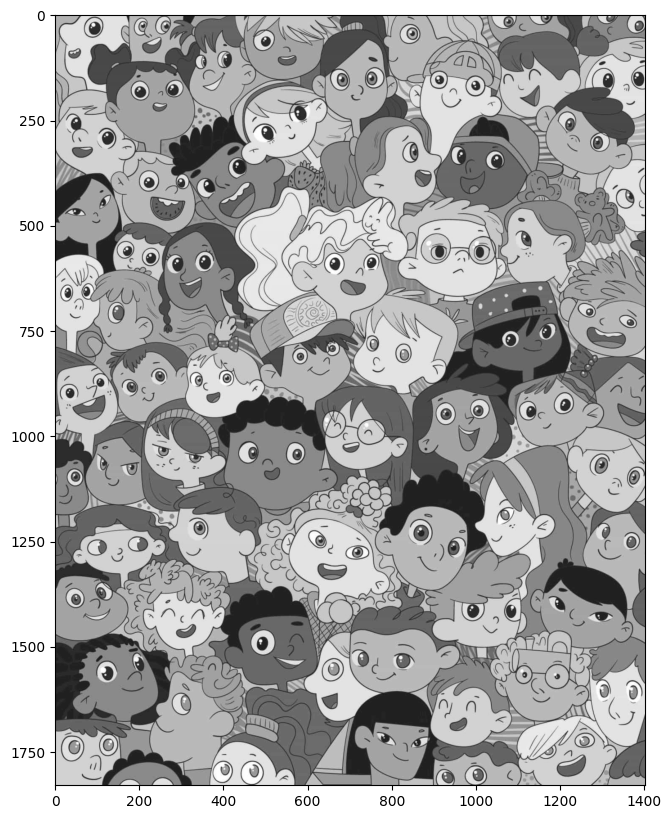

In [61]:
plt.imshow(gray, cmap='gray')

In [78]:
def templateMatching(img, template, diff: str):
    # Make a copy to avoid modifying the original image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_copy = gray.copy()

    h, w = template.shape[:2]
    height, width = gray.shape[::]
    # Select matching method
    if diff == 'SQDIFF':
        res = cv2.matchTemplate(img_copy, template, cv2.TM_SQDIFF)
    elif diff == 'SQDIFF_NORM':
        res = cv2.matchTemplate(img_copy, template, cv2.TM_SQDIFF_NORMED)
    elif diff == 'CCORR':
        res = cv2.matchTemplate(img_copy, template, cv2.TM_CCORR)
    elif diff == 'CCORR_NORM':
        res = cv2.matchTemplate(img_copy, template, cv2.TM_CCORR_NORMED)
    elif diff == 'CCOEFF':
        res = cv2.matchTemplate(img_copy, template, cv2.TM_CCOEFF)
    elif diff == 'CCOEFF_NORM':
        res = cv2.matchTemplate(img_copy, template, cv2.TM_CCOEFF_NORMED)
    
    # Find match location
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    top_left = min_loc if diff in ['SQDIFF', 'SQDIFF_NORM'] else max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    clone = img.copy()
    cv2.rectangle(clone, top_left, bottom_right, (0, 255, 0), 2)
    clone = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
    plt.imshow(clone)
    plt.axis("off")
    plt.show()


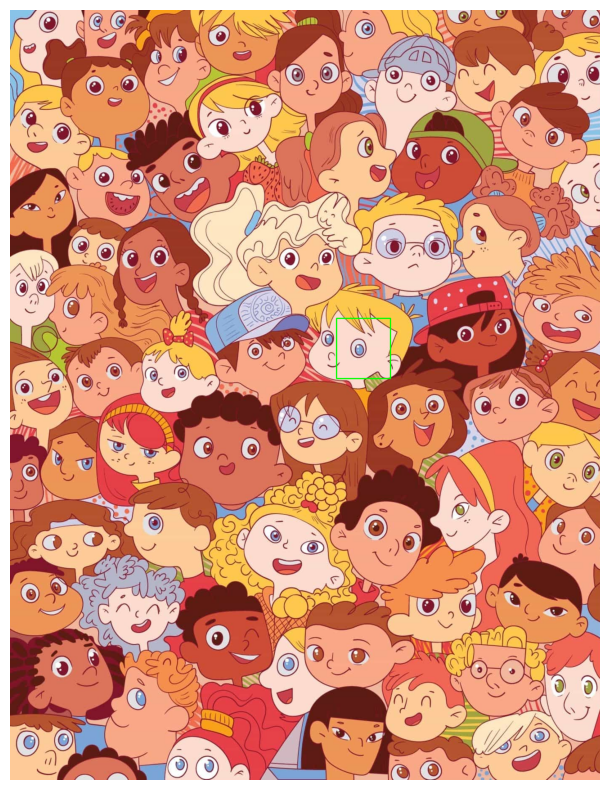

In [79]:
templateMatching(imgBGR, boat_template, "SQDIFF")

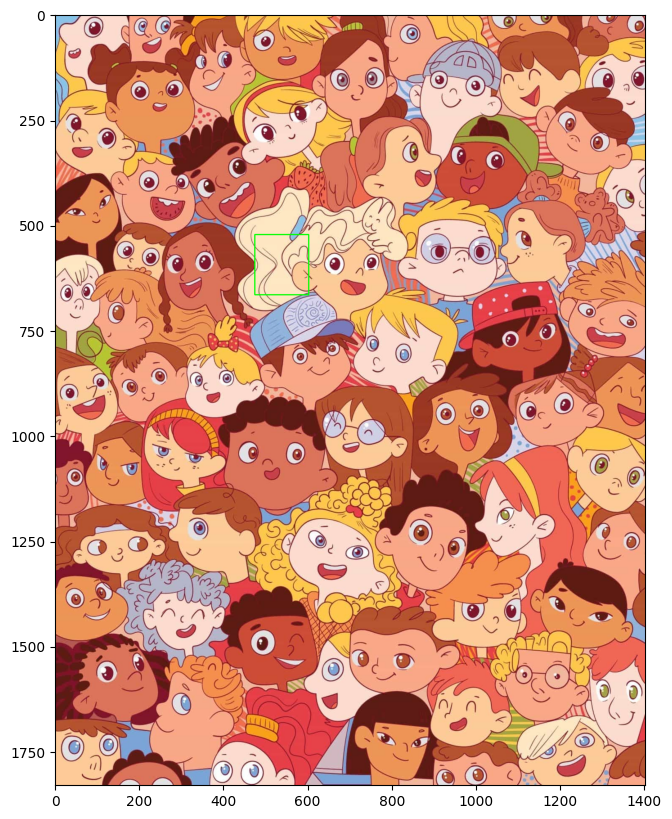

In [76]:
templateMatching(imgBGR, boat_template, "CCORR")

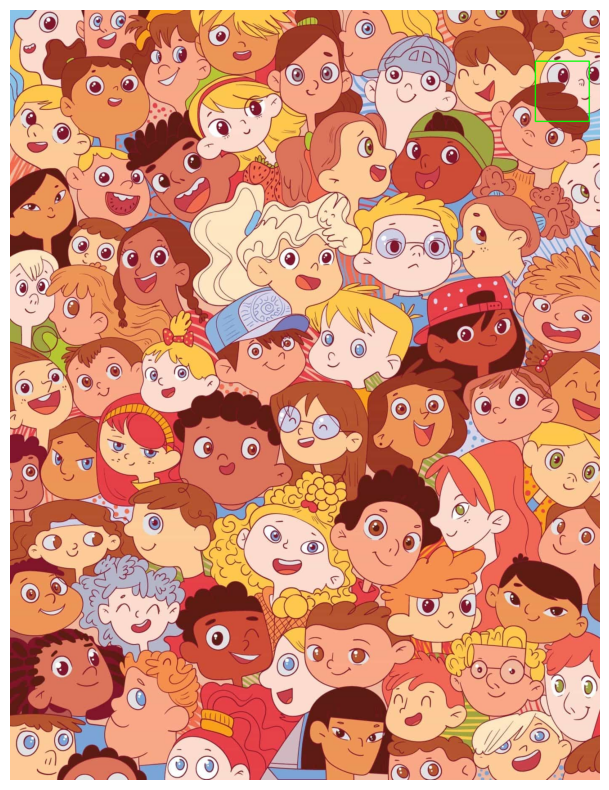

In [80]:
templateMatching(imgBGR, boat_template, "CCOEFF")

# Template matching with multi-scale

## Try with one object

In [87]:
def apply_edge_detection(image, method="canny"):
    """
    Apply different edge detection filters to the image.
    
    Parameters:
        image (numpy array): Input grayscale image.
        method (str): The edge detection method to use. Options: 'canny', 'laplacian', 'sobel', 'log'.
    
    Returns:
        numpy array: Processed edge-detected image.
    """
    if method == "canny":
        return cv2.Canny(image, 50, 200)
    elif method == "laplacian":
        return np.uint8(np.abs(cv2.Laplacian(image, cv2.CV_64F)))
    elif method == "sobel":
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        return np.uint8(np.abs(cv2.magnitude(sobel_x, sobel_y)))
    elif method == "log":  # Laplacian of Gaussian
        blurred = cv2.GaussianBlur(image, (3, 3), 0)
        return np.uint8(np.abs(cv2.Laplacian(blurred, cv2.CV_64F)))
    else:
        return image

def template_matching(imagePath, templatePath, method="canny",filter="canny"):
    """
    Perform template matching with a chosen edge detection method.
    
    Parameters:
        imagePath (str): Path to the input image.
        templatePath (str): Path to the template image.
        method (str): Edge detection method ('canny', 'laplacian', 'sobel', 'log').
    """
    template = cv2.imread(templatePath, 0)
    template = apply_edge_detection(template, filter)
    _, mask = cv2.threshold(template, 240, 255, cv2.THRESH_BINARY_INV)

    (tH, tW) = template.shape[:2]

    plt.imshow(mask, cmap='gray')
    plt.axis("off")
    plt.title("Template")
    plt.show()
    
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    found = None
    
    for scale in np.linspace(0.2, 1.0, 20)[::-1]:
        resized = imutils.resize(gray, width=int(gray.shape[1] * scale))
        r = gray.shape[1] / float(resized.shape[1])
        
        if resized.shape[0] < tH or resized.shape[1] < tW:
            break
        
        edged = apply_edge_detection(resized, method)
        result = cv2.matchTemplate(edged, template, cv2.TM_CCOEFF, mask)
        # cv2.namedWindow("Result", cv2.WINDOW_NORMAL)
        # cv2.imshow("Result", result)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)

        clone = np.dstack([edged, edged, edged])
        # cv2.namedWindow("Matched", cv2.WINDOW_NORMAL)
        # cv2.rectangle(clone, (maxLoc[0], maxLoc[1]), (maxLoc[0] + tW, maxLoc[1] + tH), (0, 255, 0), 2)
        # cv2.imshow("Matched", clone)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        
        if found is None or maxVal > found[0]:
            found = (maxVal, maxLoc, r)
    
    (_, maxLoc, r) = found
    (startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
    (endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))
    
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 10))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title(f"Template Matching Result using {method.capitalize()} Edge Detection")
    plt.show()

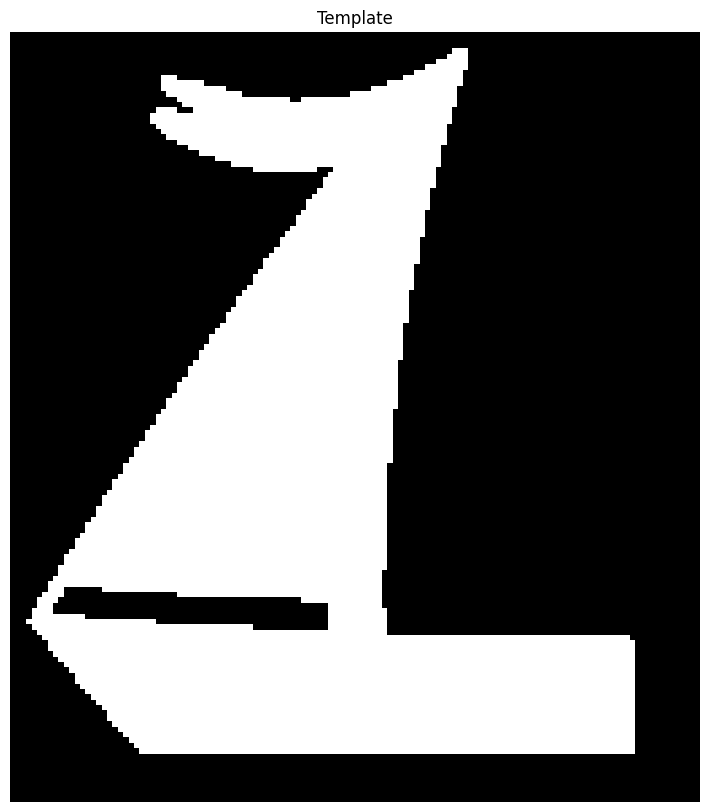

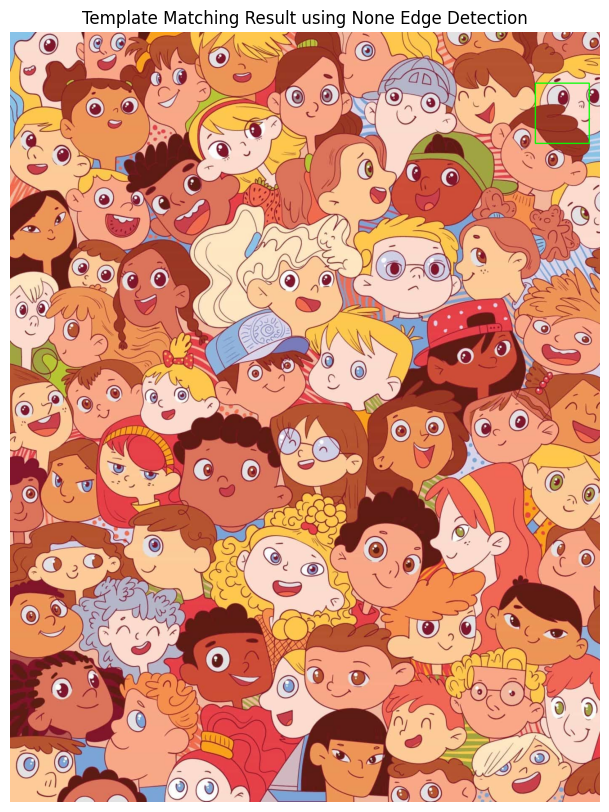

In [88]:
template_matching(os.path.join(imagePath, 'finding.jpg'), "D:\\VSC\\machine-learning-crash-course\\assets\\finding_15\\template\\boat.png", method="none",filter='none')

## Function to find all objects

In [ ]:
image = cv2.imread(os.path.join(imagePath, 'finding.jpg'))

In [41]:
def templateMatchingMultiScale(image, templateFolderPath, filter: str=None):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    for templatePath in glob.glob(templateFolderPath + "/*.png"):
        # Skip specific templates
        if any(skip in templatePath for skip in ["watermelon.png", "bow.png"]):
            print(f"Skipping {templatePath}")
            continue

        template = cv2.imread(templatePath, 0)
        found = None
        if filter == None:
            template = cv2.Canny(template, 50, 200)

        (tH, tW) = template.shape[:2]
        for scale in np.linspace(0.2, 1.0, 20)[::-1]:
            resized = imutils.resize(gray, width=int(gray.shape[1] * scale))
            r = gray.shape[1] / float(resized.shape[1]) # height ratio

            # resized's smaller than template, break
            if resized.shape[0] < tH or resized.shape[1] < tW:
                break
            
            if filter == None:
                edged = cv2.Canny(resized, 50, 200)
                result = cv2.matchTemplate(edged, template, cv2.TM_CCOEFF)

            (_, maxVal, _, maxLoc) = cv2.minMaxLoc(result)

            if found is None or maxVal > found[0]:
                found = (maxVal, maxLoc, r)

        (_, maxLoc, r) = found
        (startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
        (endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title("Template Matching Result")
    plt.show()


Skipping D:\VSC\machine-learning-crash-course\images/finding_15\template\bow.png
Skipping D:\VSC\machine-learning-crash-course\images/finding_15\template\watermelon.png


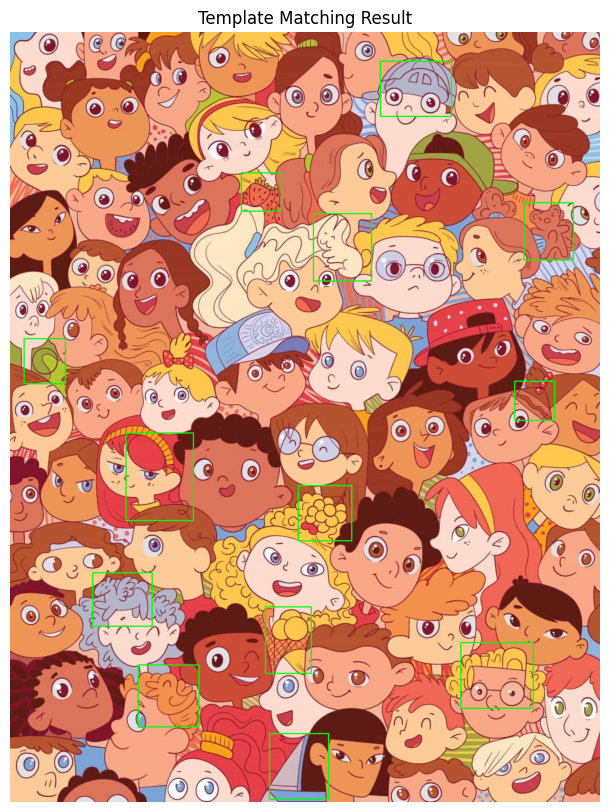

In [42]:
templateMatchingMultiScale(image, templatePath)

In [ ]:
# detect keypoints, extract local invariant descriptors, and apply keypoint matching.

In [43]:
def template_matching_with_rescale(image, template_path):
    template = cv2.imread(template_path)
    
    if image is None or template is None:
        print("Error: Unable to load image or template.")
        return
    
    # Convert images to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    
    # Create binary mask for the template (assuming a white background)
    _, mask = cv2.threshold(template_gray, 240, 255, cv2.THRESH_BINARY_INV)
    
    # Initialize best match variables
    best_scale = None
    best_min_val = float('inf')
    best_top_left = None
    best_template_w, best_template_h = None, None
    
    # Iterate over different scales
    for scale_factor in np.linspace(0.5, 1, 20):
        # Resize template
        new_width = int(template.shape[1] * scale_factor)
        new_height = int(template.shape[0] * scale_factor)
        resized_template = cv2.resize(template_gray, (new_width, new_height), interpolation=cv2.INTER_AREA)
        resized_mask = cv2.resize(mask, (new_width, new_height), interpolation=cv2.INTER_AREA)
        
        # Perform template matching
        try:
            result = cv2.matchTemplate(image_gray, resized_template, cv2.TM_SQDIFF_NORMED, mask=resized_mask)

        except cv2.error as e:
            print("Error during template matching:", e)
            continue
        
        # Find best match location
        min_val, _, min_loc, _ = cv2.minMaxLoc(result)

        # clone = image.copy()
        # cv2.rectangle(clone, min_loc, (min_loc[0] + resized_template.shape[0], min_loc[1] + resized_template.shape[1]), (0, 255, 0), 2)
        # cv2.namedWindow("Matched", cv2.WINDOW_NORMAL)
        # cv2.imshow("Matched", clone)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        # Update best match if found
        if min_val < best_min_val:
            best_min_val = min_val
            best_scale = scale_factor
            best_top_left = min_loc
            best_template_w, best_template_h = resized_template.shape[:2]
    
    # Visualization
    if best_top_left is not None:
        # Draw the best match rectangle on the original image
        top_left = best_top_left
        bottom_right = (top_left[0] + best_template_w, top_left[1] + best_template_h)
        
        cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.axis("off")
        plt.show()
        print(f"Best scale factor: {best_scale}")
        print(f"Best matching value (min_val): {best_min_val}")
        
    else:
        print("No match found.")


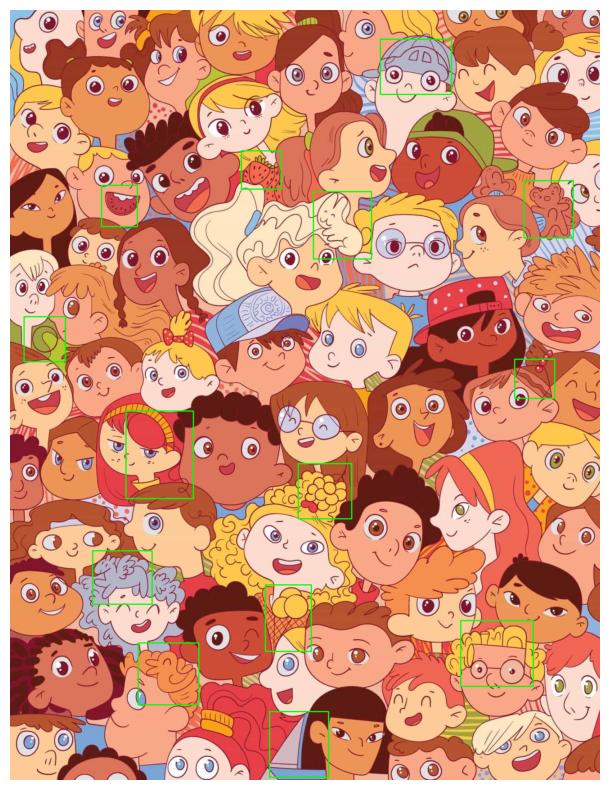

Best scale factor: 0.868421052631579
Best matching value (min_val): 0.02981308475136757


In [44]:
template_matching_with_rescale(image,  
                                'D:\\VSC\\machine-learning-crash-course\\images\\finding_15\\template\\watermelon.png')

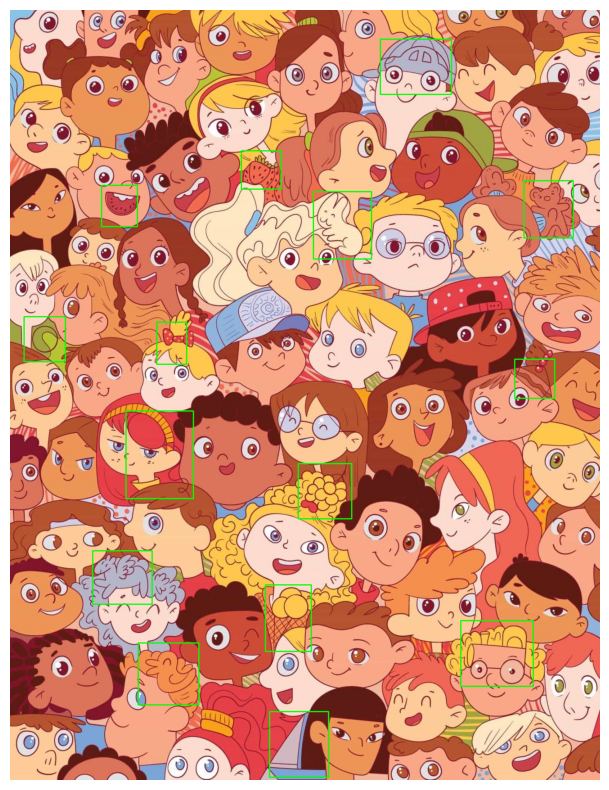

Best scale factor: 0.8421052631578947
Best matching value (min_val): 0.055217087268829346


In [46]:
template_matching_with_rescale(image,  
                                'D:\\VSC\\machine-learning-crash-course\\images\\finding_15\\template\\bow.png')

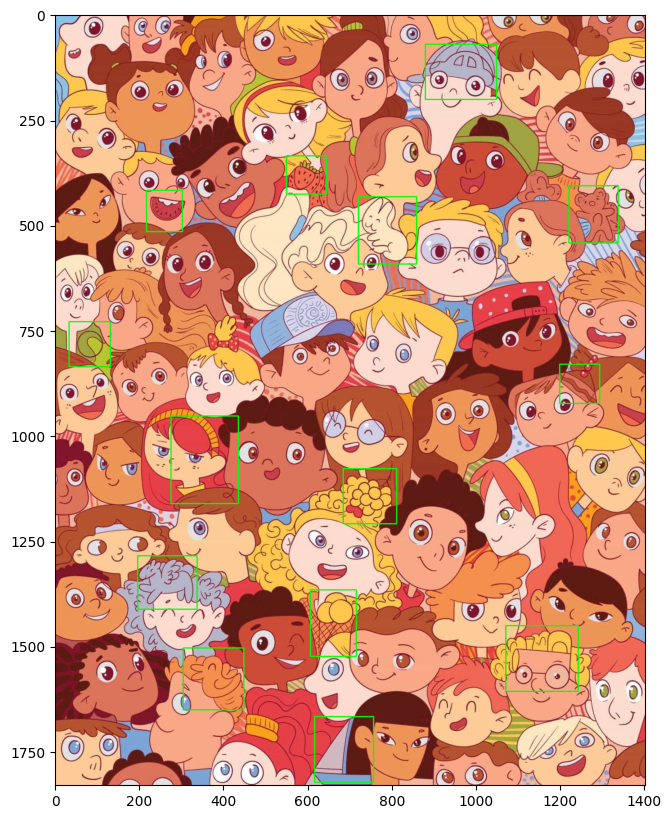

In [45]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))